In [ ]:
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import optax


I chose Sunspots Dataset from https://www.kaggle.com/datasets/robervalt/sunspots/data It is a Time-Series Dataset where we need to predict amount of Sunspots at a certain month - Part of Sun's photosphere which is darker then surrounding areas, they have also reduced surface temperature. Suspots usually apear in pairs of opposite magnetic polarities and their number varies according to the approximately 11-year solar cycle.

 There is only one given feature so there is no need for embedings. We will cut the dataset on three parts: train, validation and test. First two will be used during training(validation to check model performance), and the last one for the final test.

In [ ]:
#DOWNLOADING DATASET FROM KAGGLE

!pip install kaggle
from google.colab import drive
drive.mount('/content/drive')

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d robervalt/sunspots

!unzip sunspots.zip

Mounted at /content/drive
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/robervalt/sunspots
License(s): CC0-1.0
  0% 0.00/22.4k [00:00<?, ?B/s]
100% 22.4k/22.4k [00:00<00:00, 2.72MB/s]
Archive:  sunspots.zip
  inflating: Sunspots.csv            


In [ ]:
import pandas as pd
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt

df = pd.read_csv('Sunspots.csv')

In [ ]:
def create_sequences_targets(df, seq_length):
    sequences = []
    targets = []
    data = df['Monthly Mean Total Sunspot Number'].values

    for i in range(0, len(data) - seq_length):
        sequence = data[i : i + seq_length]
        # At this point target is the next value after the sequence
        target = data[i + seq_length]
        sequences.append(sequence)
        targets.append(target)

    return jnp.array(sequences), jnp.array(targets)

In [ ]:
#Creating sequences of length 20 and target for them(next value)
sequence_length = 20
sequences, targets = create_sequences_targets(df, sequence_length)

In [ ]:
# We are taking consistently train_ratio part of dataset to train,
# then from the end of the train til train_ratio + val_ratio part is validation part
# end from the end of validation part till the end is test part
def train_val_test_split(sequences, targets, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
  n_samples = len(sequences)
  train_size = int(n_samples * train_ratio)
  val_size = int(n_samples * val_ratio)
  test_size = n_samples - train_size - val_size

  train_sequences = sequences[:train_size]
  train_targets = targets[:train_size]

  val_sequences = sequences[train_size:(train_size + val_size)]
  val_targets = targets[train_size:(train_size + val_size)]

  test_sequences = sequences[(train_size + val_size):]
  test_targets = targets[(train_size + val_size):]

  return (train_sequences, train_targets), (val_sequences, val_targets), (test_sequences, test_targets)

In [ ]:
(train_sequences, train_targets), (val_sequences, val_targets), (test_sequences, test_targets) = train_val_test_split(sequences, targets)

###Training a recurrent model



**TODO**: Create and Train 1)Conv1d+LSTM Model 2) LSTM Model 3)sLSTM Model. Implement all necesary functions for their building as: init functions, call functions, init functions, forward functions, loss functions and update.

LSTM and sLSTM based on "xLSTM: Extended Long Short-Term Memory" (https://arxiv.org/abs/2405.04517) by Maximilian Beck, Korbinian Pöppel, Markus Spanring, Andreas Auer, Oleksandra Prudnikova, Michael Kopp, Günter Klambauer, Johannes Brandstetter, Sepp Hochreiter.

In [ ]:
# Activation functions
def relu(input):
    return jnp.maximum(0, input)

from jax.nn import gelu, sigmoid
from jax.numpy import tanh
import jax.random as random

LSTM:
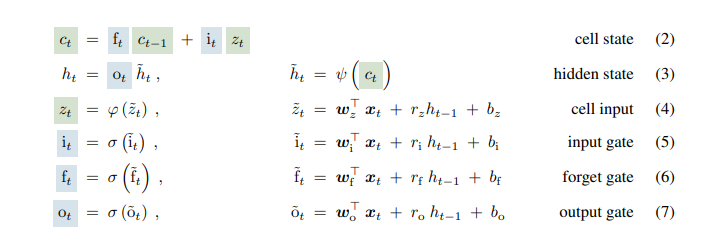

In [ ]:
# Params Initialiazation

def lstm_init(input_size, hidden_size, key):
    forget_key, input_key, candidate_key, output_key = random.split(key, 4)

    # Limit for Xavier uniform
    fan_in = input_size + hidden_size
    fan_out = hidden_size
    limit = jnp.sqrt(6.0 / (fan_in + fan_out))

    # Random weights from uniform distribution for both Input and Short-Term Memory

    # We are projecting from the concatenation of Hidden State and Input into
    # into space of Hidden State size

    # Forget Gate Weights
    f_w = random.uniform(forget_key, (fan_in, fan_out), minval=-limit, maxval=limit)
    f_b = jnp.zeros(fan_out)
    # Input Gate Weights
    i_w = random.uniform(input_key, (fan_in, fan_out), minval=-limit, maxval=limit)
    i_b = jnp.zeros(fan_out)
    # Candidate Gate Weights
    c_w = random.uniform(candidate_key, (fan_in, fan_out), minval=-limit, maxval=limit)
    c_b = jnp.zeros(fan_out)
    # Output Gate Weights
    o_w = random.uniform(output_key, (fan_in, fan_out), minval=-limit, maxval=limit)
    o_b = jnp.zeros(fan_out)

    return f_w, f_b, i_w, i_b, c_w, c_b, o_w, o_b

def slstm_init(input_size, hidden_size, key):
    forget_key, input_key, candidate_key, output_key = random.split(key, 4)

    # Limit for Xavier uniform
    fan_in = input_size + hidden_size
    fan_out = hidden_size
    limit = jnp.sqrt(6.0 / (fan_in + fan_out))

    # Random weights from uniform distribution for both Input and Short-Term Memory

    # We are projecting from the concatenation of Hidden State and Input into
    # into space of Hidden State size

    # Forget Gate Weights
    f_w = random.uniform(forget_key, (fan_in, fan_out), minval=-limit, maxval=limit)
    f_b = jnp.zeros(fan_out)
    # Input Gate Weights
    i_w = random.uniform(input_key, (fan_in, fan_out), minval=-limit, maxval=limit)
    i_b = jnp.zeros(fan_out)
    # Candidate Gate Weights
    c_w = random.uniform(candidate_key, (fan_in, fan_out), minval=-limit, maxval=limit)
    c_b = jnp.zeros(fan_out)
    # Output Gate Weights
    o_w = random.uniform(output_key, (fan_in, fan_out), minval=-limit, maxval=limit)
    o_b = jnp.zeros(fan_out)

    return f_w, f_b, i_w, i_b, c_w, c_b, o_w, o_b

def initialize_dense(input_dim, output_dim, key):
    w_key, b_key = random.split(key)

    limit = jnp.sqrt(6.0 / (input_dim + output_dim))

    w = random.uniform(w_key, (input_dim, output_dim), minval=-limit, maxval=limit)
    b = jnp.zeros(output_dim)

    return w, b

def initialize_1d_conv(chanels, size, key):
    key, subkey = random.split(key)
    convolutions = random.uniform(subkey, (chanels, size))
    return convolutions

sLSTM: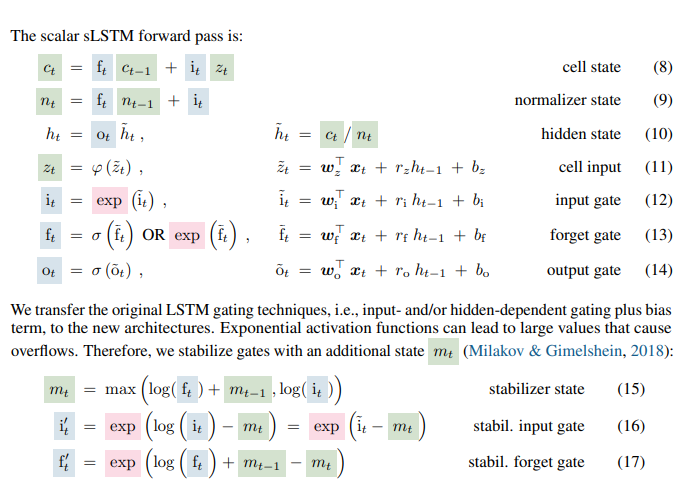

In [ ]:
def dense(x, dense_params):
    w, b = dense_params
    return jnp.matmul(x, w) + b

def lstm_cell(params, x, h, c):
    concat = jnp.concatenate((x, h), axis=-1)
    f_w, f_b, i_w, i_b, c_w, c_b, o_w, o_b = params

    #values to forget
    f = sigmoid(jnp.matmul(concat, f_w) + f_b)
    #values to update
    i = sigmoid(jnp.matmul(concat, i_w) + i_b)
    #creating a candidate to update long-term memory
    c_tilda = tanh(jnp.matmul(concat, c_w) + c_b)

    #updating long-term memory(Masking)
    #TANH() is important here
    new_c = tanh(f*c + i*c_tilda)

    #output gate
    o = sigmoid(jnp.matmul(concat, o_w).T + o_b)
    #output <=> new_h
    new_h = o*tanh(new_c)

    return new_h, new_c

def slstm_cell(params, x, h, c, n, m, epsilon=1e-8):
    concat = jnp.concatenate((x, h), axis=-1)
    f_w, f_b, i_w, i_b, c_w, c_b, o_w, o_b = params

    #values to forget
    #sigmoid was chosen, but exp can also be applied
    f_t = jax.nn.sigmoid(jnp.matmul(concat, f_w) + f_b)
    #values to update(without activation)
    i_t = jnp.matmul(concat, i_w) + i_b

    #update stabilizing state
    new_m = jnp.maximum(jnp.log(f_t + epsilon) + m, i_t)

    #stabilize f_t and i_t
    f_t = jnp.exp(jnp.log(f_t + epsilon) + m - new_m)
    i_t = jnp.exp(i_t - new_m)

    #creating a candidate to update long-term memory
    c_tilda = jax.nn.tanh(jnp.matmul(concat, c_w) + c_b)

    #updating long-term memory(Masking)
    new_c = f_t * c + i_t * c_tilda

    #output gate
    o_t = jax.nn.sigmoid(jnp.matmul(concat, o_w) + o_b)

    #normalizer state update
    new_n = n * new_c + i_t

    #updating h
    new_h = o_t * (new_c / (new_n + epsilon))

    new_c = sigmoid(new_c)
    new_h = tanh(new_h)

    return new_h, new_c, new_n, new_m


# Creating actual convolution function for multi-chanel input and multi-chanel output

# First vectorizing over kernel chanells, then over input chanells, and in the end
# Summing convolutions of kernel and every input chanel
def chaneled_convolve(example, conv_params, mode='valid'):
  new_conv = jax.vmap(jax.vmap(jnp.convolve, in_axes = (None, 0, None)), in_axes = (1, None , None))
  return jnp.sum(new_conv(example, conv_params, mode), axis = 0)

In [ ]:
# Defining and testing LSTM and sLSTM cycles

@jax.jit
def lstm_forward(params, inputs):
  h = jnp.zeros((params[0].shape[1]))  #hidden state
  c = jnp.zeros((params[0].shape[1]))  #cell state
  outputs = []
  for x in inputs:
    h, c = lstm_cell(params, x, h, c)
    outputs.append(h)
  return jnp.array(outputs)

@jax.jit
def slstm_forward(params, inputs):
    h = jnp.zeros((params[0].shape[1]))  #hidden state
    c = jnp.zeros((params[0].shape[1]))  #cell state
    n = jnp.ones((params[0].shape[1]))  #normalizer state
    m = jnp.ones((params[0].shape[1])) #stabilizing state
    outputs = []
    for x in inputs:
        h, c, n, m = slstm_cell(params, x, h, c, n, m)
        outputs.append(h)
    return jnp.array(outputs)

key = random.PRNGKey(0)
input_size = 1
hidden_size = 16
batch_size = 4
sequence_length = 20

params = lstm_init(input_size, hidden_size, key)

batch_seqs = train_sequences[0:batch_size].reshape((batch_size, sequence_length, input_size))

# Batched Forward Pass
batched_lstm_forward = jax.vmap(lstm_forward, in_axes=(None, 0))
batched_slstm_forward = jax.vmap(slstm_forward, in_axes=(None, 0))

batched_outputs_lstm = batched_lstm_forward(params, batch_seqs)
batched_output_slstm = batched_slstm_forward(params, batch_seqs)

print("Batched LSTM Outputs Shape:", batched_outputs_lstm.shape)
print("Batched sLSTM Outputs Shape:", batched_output_slstm.shape)

Batched LSTM Outputs Shape: (4, 20, 16)
Batched sLSTM Outputs Shape: (4, 20, 16)


# Models:
>1) **Convolution + LSTMs**

>2) **LSTMs**

>3) **sLSTMs**

In [ ]:
# Convoluion + LSTMs Model

conv_net_parameters = {}

input_size = 1
# CONV1D parameters
key, subkey = random.split(key)
channels = 8
conv1d_params = initialize_1d_conv(channels, 4, subkey)
conv_net_parameters["conv1d_params"] = conv1d_params

# LSTM 1 parameters
key, subkey = random.split(key)
hidden_size = 32
conv_net_parameters["lstm1_params"] = lstm_init(channels, hidden_size, subkey)

# LSTM 2 parameters
key, subkey = random.split(key)
conv_net_parameters["lstm2_params"] = lstm_init(hidden_size, 4*hidden_size, subkey)

# Dense parameters
key, subkey = random.split(key)
dense1_dim = 64
conv_net_parameters["dense1_params"] = initialize_dense(4*hidden_size, dense1_dim, subkey)

# Dense 2 parameters
key, subkey = random.split(key)
dense2_dim = 32
conv_net_parameters["dense2_params"] = initialize_dense(dense1_dim, dense2_dim, subkey)

# Output Dense Layer parameters
key, subkey = random.split(key)
output_dim = input_size # Output dimension same as input size
conv_net_parameters["output_dense_params"] = initialize_dense(dense2_dim, output_dim, subkey)

@jax.jit
def conv_net_forward_pass(params, inputs):
    # CONV1D
    conv1d_out = chaneled_convolve(inputs, params["conv1d_params"], 'same')
    # Swapping axes in order to LSTM to process data correctly
    conv1d_out = conv1d_out.swapaxes(-1, -2)

    # LSTM 1
    lstm1_out = lstm_forward(params["lstm1_params"], conv1d_out)

    # LSTM 2
    lstm2_out = lstm_forward(params["lstm2_params"], lstm1_out)

    # Dense Layer
    dense1_out = dense(lstm2_out[-1], params["dense1_params"])
    dense1_out = relu(dense1_out)

    dense2_out = dense(dense1_out, params["dense2_params"])
    dense2_out = relu(dense2_out)

    # Output Dense Layer
    final_out = dense(dense2_out, params["output_dense_params"])

    return final_out

In [ ]:
# LSTMs Model

lstm_net_parameters = {}

input_size = 1

# LSTM 1 parameters
key, subkey = random.split(key)
hidden_size = 64
lstm_net_parameters["lstm1_params"] = lstm_init(input_size, hidden_size, subkey)

# # Layer Norm after LSTM 1
# net_parameters["lstm1_layernorm_params"] = initialize_layer_norm(hidden_size)

# LSTM 2 parameters
key, subkey = random.split(key)
lstm_net_parameters["lstm2_params"] = lstm_init(hidden_size, hidden_size, subkey)

# LSTM 3 parameters
key, subkey = random.split(key)
lstm_net_parameters["lstm3_params"] = lstm_init(hidden_size, hidden_size // 2, subkey)


# Dense parameters
key, subkey = random.split(key)
dense1_dim = 64
lstm_net_parameters["dense1_params"] = initialize_dense(hidden_size // 2, dense1_dim, subkey)

# Dense 2 parameters
key, subkey = random.split(key)
dense2_dim = 64
lstm_net_parameters["dense2_params"] = initialize_dense(dense1_dim, dense2_dim, subkey)

# Output Dense Layer parameters
key, subkey = random.split(key)
output_dim = input_size # Output dimension same as input size
lstm_net_parameters["output_dense_params"] = initialize_dense(dense2_dim, output_dim, subkey)


def lstm_net_forward_pass(params, inputs):
    # LSTM 1
    lstm1_out = lstm_forward(params["lstm1_params"], inputs)

    # LSTM 2
    lstm2_out = lstm_forward(params["lstm2_params"], lstm1_out)

    # LSTM 3
    lstm3_out = lstm_forward(params["lstm3_params"], lstm2_out)

    # Dense Layer
    dense1_out = dense(lstm3_out[-1], params["dense1_params"])
    dense1_out = jax.nn.gelu(dense1_out)

    dense2_out = dense(dense1_out, params["dense2_params"])
    dense2_out = jax.nn.gelu(dense2_out)

    # Output Dense Layer
    final_out = dense(dense2_out, params["output_dense_params"])

    return final_out

In [ ]:
# sLSTM Model
# Architecture is the same as for LSTM Model
key = random.PRNGKey(0)
slstm_net_parameters = {}

input_size = 1

# sLSTM 1 parameters
key, subkey = random.split(key)
hidden_size = 64
slstm_net_parameters["slstm1_params"] = slstm_init(input_size, hidden_size, subkey)

# sLSTM 2 parameters
key, subkey = random.split(key)
slstm_net_parameters["slstm2_params"] = slstm_init(hidden_size, hidden_size, subkey)

# sLSTM 3 parameters
key, subkey = random.split(key)
slstm_net_parameters["slstm3_params"] = slstm_init(hidden_size, hidden_size // 2, subkey)


# Dense parameters
key, subkey = random.split(key)
dense1_dim = 64
slstm_net_parameters["dense1_params"] = initialize_dense(hidden_size // 2, dense1_dim, subkey)

# Dense 2 parameters
key, subkey = random.split(key)
dense2_dim = 64
slstm_net_parameters["dense2_params"] = initialize_dense(dense1_dim, dense2_dim, subkey)

# Output Dense Layer parameters
key, subkey = random.split(key)
output_dim = input_size # Output dimension same as input size
slstm_net_parameters["output_dense_params"] = initialize_dense(dense2_dim, output_dim, subkey)


def slstm_forward_pass(params, inputs):

    # sLSTM 1
    slstm1_out = slstm_forward(params["slstm1_params"], inputs)

    # sLSTM 2
    slstm2_out = slstm_forward(params["slstm2_params"], slstm1_out)

    # sLSTM 3
    slstm3_out = slstm_forward(params["slstm3_params"], slstm2_out)

    # Dense Layer
    dense1_out = dense(slstm3_out[-1], params["dense1_params"])
    dense1_out = jax.nn.gelu(dense1_out)

    dense2_out = dense(dense1_out, params["dense2_params"])
    dense2_out = jax.nn.gelu(dense2_out)

    # Output Dense Layer
    final_out = dense(dense2_out, params["output_dense_params"])

    return final_out

In [ ]:
#MSE LOSS WITH L2 REGULARIZATION
@jax.jit
def loss_reg(params, inputs, targets, l2_reg=0.001):
    # Forward pass
    predictions = jax.vmap(conv_net_forward_pass, in_axes=(None, 0))(params, inputs)

    # Calculate MSE loss
    mse_loss = jnp.mean((predictions - targets)**2)

    # Calculate L2 regularization term
    reg_loss = 0
    for key, value in params.items():
        if key:
            if isinstance(value, tuple):
                for element in value:
                    l2_reg += jnp.sum(jnp.square(element))
            else:
                l2_reg += jnp.sum(jnp.square(value))

    # Total loss
    total_loss = mse_loss + reg_loss * l2_reg

    return total_loss

@jax.jit
def loss_fn(params, batch, targets):
    # Forward pass
    predictions = jax.jit(jax.vmap(conv_net_forward_pass, in_axes=(None, 0)))(params, batch)

    # Mean absolute error
    loss = jnp.mean(jnp.abs(targets - predictions))
    # loss = jnp.mean((predictions - targets)**2)**0.5
    return loss

# Update Using loss with regularization
@jax.jit
def update_reg(params, opt_state, batch_seqs, batch_targets):
    grads = jax.grad(loss_reg)(params, batch_seqs, batch_targets)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

# Update using usual loss
@jax.jit
def update(params, opt_state, batch_seqs, batch_targets):
    grads = jax.grad(loss_fn)(params, batch_seqs, batch_targets)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

#We need to reshape targets in order to gradient and loss be calculated properly
reshaped_train_targets = train_targets.reshape(train_targets.shape[0], -1)

In [ ]:
# For Conv + LSTM model I first train at with regularization, and then check
# how loss changes if I'll remove it

# Initialize optimizer
optimizer = optax.adam(3e-5)
opt_state = optimizer.init(conv_net_parameters)
# Training loop
epochs = 400
batch_size = 64


training_losses_conv = []
validation_losses_conv = []

for epoch in range(epochs):
  #randomly select batch_size sequences from train_sequences
  key, subkey = random.split(key)
  indecies = jnp.arange(train_sequences.shape[0])
  indecies = random.permutation(subkey, indecies)
  n_batches = train_sequences.shape[0] // batch_size
  total_epoch_loss = 0
  for i in range(train_sequences.shape[0] // batch_size):
    idx = indecies[i*batch_size:(i+1)*batch_size]
    batch_seqs = train_sequences[idx].reshape((batch_size, sequence_length, input_size))
    batch_targets = reshaped_train_targets[idx]
    # Update parameters with regularized loss first 75% epochs
    # Then with usual loss
    if epoch <  3 * epochs // 4:
      conv_net_parameters, opt_state = update_reg(conv_net_parameters, opt_state, batch_seqs, batch_targets)
    else:
      conv_net_parameters, opt_state = update(conv_net_parameters, opt_state, batch_seqs, batch_targets)

    now_loss = loss_fn(conv_net_parameters, batch_seqs, batch_targets)
    total_epoch_loss += now_loss
  # Actual loss during epoch
  total_epoch_loss /= n_batches

  # Print the val every few epochs
  if epoch % 5 == 0:
      reshaped_val_seqs = val_sequences.reshape((val_sequences.shape[0], sequence_length, input_size))
      reshaped_val_targets = val_targets.reshape(val_targets.shape[0], -1)
      val_loss = loss_fn(conv_net_parameters, reshaped_val_seqs, reshaped_val_targets)

      training_losses_conv.append(total_epoch_loss)
      validation_losses_conv.append(val_loss)

      print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")
      print(f" Training Loss: {total_epoch_loss:.4f}")

Epoch 1, Validation Loss: 104.4020
 Training Loss: 76.7066
Epoch 6, Validation Loss: 103.4028
 Training Loss: 75.8134
Epoch 11, Validation Loss: 98.1562
 Training Loss: 71.5716
Epoch 16, Validation Loss: 92.2577
 Training Loss: 65.9931
Epoch 21, Validation Loss: 86.9308
 Training Loss: 62.4814
Epoch 26, Validation Loss: 82.1233
 Training Loss: 58.7632
Epoch 31, Validation Loss: 77.9036
 Training Loss: 55.8067
Epoch 36, Validation Loss: 74.5039
 Training Loss: 53.3091
Epoch 41, Validation Loss: 71.6336
 Training Loss: 51.5788
Epoch 46, Validation Loss: 69.5057
 Training Loss: 48.9384
Epoch 51, Validation Loss: 67.9698
 Training Loss: 46.5034
Epoch 56, Validation Loss: 64.7903
 Training Loss: 43.1949
Epoch 61, Validation Loss: 53.7111
 Training Loss: 35.1833
Epoch 66, Validation Loss: 48.0708
 Training Loss: 30.0594
Epoch 71, Validation Loss: 44.4174
 Training Loss: 27.3191
Epoch 76, Validation Loss: 40.2473
 Training Loss: 25.0693
Epoch 81, Validation Loss: 37.4721
 Training Loss: 23.70

In [ ]:
# The LSTM is trained with MAE loss without regularization

# We need to update loss for another forward pass
@jax.jit
def loss_fn(params, batch, targets):
    # Forward pass
    predictions = jax.jit(jax.vmap(lstm_net_forward_pass, in_axes=(None, 0)))(params, batch)

    # Mean absolute error
    loss = jnp.mean(jnp.abs(targets - predictions))
    # loss = jnp.mean((predictions - targets)**2)**0.5
    return loss


# Initialize optimizer
optimizer = optax.adam(3e-5)
opt_state = optimizer.init(lstm_net_parameters)

# Training loop
epochs = 400
batch_size = 64

#We need to reshape targets in order to gradient and loss be calculated properly
reshaped_train_targets = train_targets.reshape(train_targets.shape[0], -1)

training_losses_lstm = []
validation_losses_lstm = []

for epoch in range(epochs):
  #randomly select batch_size sequences from train_sequences
  key, subkey = random.split(key)
  indecies = jnp.arange(train_sequences.shape[0])
  indecies = random.permutation(subkey, indecies)
  n_batches = train_sequences.shape[0] // batch_size
  total_epoch_loss = 0
  for i in range(n_batches):
    idx = indecies[i*batch_size:(i+1)*batch_size]
    batch_seqs = train_sequences[idx].reshape((batch_size, sequence_length, input_size))
    batch_targets = reshaped_train_targets[idx]
    # Update parameters
    lstm_net_parameters, opt_state = update(lstm_net_parameters, opt_state, batch_seqs, batch_targets)
    now_loss = loss_fn(lstm_net_parameters, batch_seqs, batch_targets)
    total_epoch_loss += now_loss
  total_epoch_loss /= n_batches
  # Print the val every few epochs
  if epoch % 5 == 0:
      reshaped_val_seqs = val_sequences.reshape((val_sequences.shape[0], sequence_length, input_size))
      reshaped_val_targets = val_targets.reshape(val_targets.shape[0], -1)

      val_loss = loss_fn(lstm_net_parameters, reshaped_val_seqs, reshaped_val_targets)
      print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")
      print(f" Training Loss: {total_epoch_loss:.4f}")

      training_losses_lstm.append(total_epoch_loss)
      validation_losses_lstm.append(val_loss)

Epoch 1, Validation Loss: 104.4069
 Training Loss: 76.5900
Epoch 6, Validation Loss: 103.9550
 Training Loss: 76.1367
Epoch 11, Validation Loss: 102.3405
 Training Loss: 74.5725
Epoch 16, Validation Loss: 98.5154
 Training Loss: 71.6296
Epoch 21, Validation Loss: 93.4871
 Training Loss: 67.3556
Epoch 26, Validation Loss: 88.6809
 Training Loss: 63.2334
Epoch 31, Validation Loss: 83.9074
 Training Loss: 59.1699
Epoch 36, Validation Loss: 78.5262
 Training Loss: 54.3841
Epoch 41, Validation Loss: 72.9555
 Training Loss: 49.3740
Epoch 46, Validation Loss: 67.7087
 Training Loss: 44.6926
Epoch 51, Validation Loss: 62.6434
 Training Loss: 40.4983
Epoch 56, Validation Loss: 57.6673
 Training Loss: 36.6004
Epoch 61, Validation Loss: 53.4144
 Training Loss: 33.1718
Epoch 66, Validation Loss: 49.6365
 Training Loss: 30.6641
Epoch 71, Validation Loss: 46.7434
 Training Loss: 28.6929
Epoch 76, Validation Loss: 44.0869
 Training Loss: 27.2622
Epoch 81, Validation Loss: 41.7853
 Training Loss: 25.8

In [ ]:
# The sLSTM the same way as LSTM: with MAE loss without regularization

# We need to update loss for another forward pass
# Another Weight inicialization for sLSTM is necesary for proper gradient calculation
@jax.jit
def loss_fn(params, batch, targets):
    # Forward pass
    predictions = jax.jit(jax.vmap(slstm_forward_pass, in_axes=(None, 0)))(params, batch)

    # Mean absolute error
    loss = jnp.mean(jnp.abs(targets - predictions))
    # loss = jnp.mean((predictions - targets)**2)**0.5
    return loss

# Update function needs to be changed, because it was compled for another loss_fn then now
@jax.jit
def update(params, opt_state, batch_seqs, batch_targets):
    grads = jax.grad(loss_fn)(params, batch_seqs, batch_targets)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

# Initialize optimizer
optimizer = optax.adam(3e-5)
opt_state = optimizer.init(slstm_net_parameters)

# Training loop
epochs = 400
batch_size = 64

#We need to reshape targets in order to gradient and loss be calculated properly
# reshaped_train_targets = train_targets.reshape(train_targets.shape[0], -1)

slstm_training_losses = [] # Initialize empty lists
slstm_validation_losses = []

for epoch in range(epochs):
  #randomly select batch_size sequences from train_sequences
  key, subkey = random.split(key)
  indecies = jnp.arange(train_sequences.shape[0])
  indecies = random.permutation(subkey, indecies)
  n_batches = train_sequences.shape[0] // batch_size
  total_epoch_loss = 0
  for i in range(n_batches):
    idx = indecies[i*batch_size:(i+1)*batch_size]
    batch_seqs = train_sequences[idx].reshape((batch_size, sequence_length, input_size))
    batch_targets = reshaped_train_targets[idx]
    # Update parameters
    slstm_net_parameters, opt_state = update(slstm_net_parameters, opt_state, batch_seqs, batch_targets)
    now_loss = loss_fn(slstm_net_parameters, batch_seqs, batch_targets)
    total_epoch_loss += now_loss
  total_epoch_loss /= n_batches
  # Print the val every few epochs
  if epoch % 5 == 0:
      reshaped_val_seqs = val_sequences.reshape((val_sequences.shape[0], sequence_length, input_size))
      reshaped_val_targets = val_targets.reshape(val_targets.shape[0], -1)

      val_loss = loss_fn(slstm_net_parameters, reshaped_val_seqs, reshaped_val_targets)
      print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")
      print(f" Training Loss: {total_epoch_loss:.4f}")

      slstm_training_losses.append(total_epoch_loss)
      slstm_validation_losses.append(val_loss)

Epoch 1, Validation Loss: 104.4994
 Training Loss: 76.9095
Epoch 6, Validation Loss: 104.2402
 Training Loss: 76.5303
Epoch 11, Validation Loss: 102.8700
 Training Loss: 75.5303
Epoch 16, Validation Loss: 99.6883
 Training Loss: 72.5735
Epoch 21, Validation Loss: 97.3250
 Training Loss: 70.2589
Epoch 26, Validation Loss: 95.2397
 Training Loss: 68.3207
Epoch 31, Validation Loss: 93.4990
 Training Loss: 67.4946
Epoch 36, Validation Loss: 92.5945
 Training Loss: 66.3013
Epoch 41, Validation Loss: 92.6168
 Training Loss: 66.4039
Epoch 46, Validation Loss: 91.4147
 Training Loss: 65.7802
Epoch 51, Validation Loss: 90.4541
 Training Loss: 64.7658
Epoch 56, Validation Loss: 85.9208
 Training Loss: 61.5448
Epoch 61, Validation Loss: 81.3781
 Training Loss: 57.9566
Epoch 66, Validation Loss: 78.1995
 Training Loss: 54.6267
Epoch 71, Validation Loss: 77.6891
 Training Loss: 53.9984
Epoch 76, Validation Loss: 76.8954
 Training Loss: 52.6007
Epoch 81, Validation Loss: 74.9336
 Training Loss: 51.1

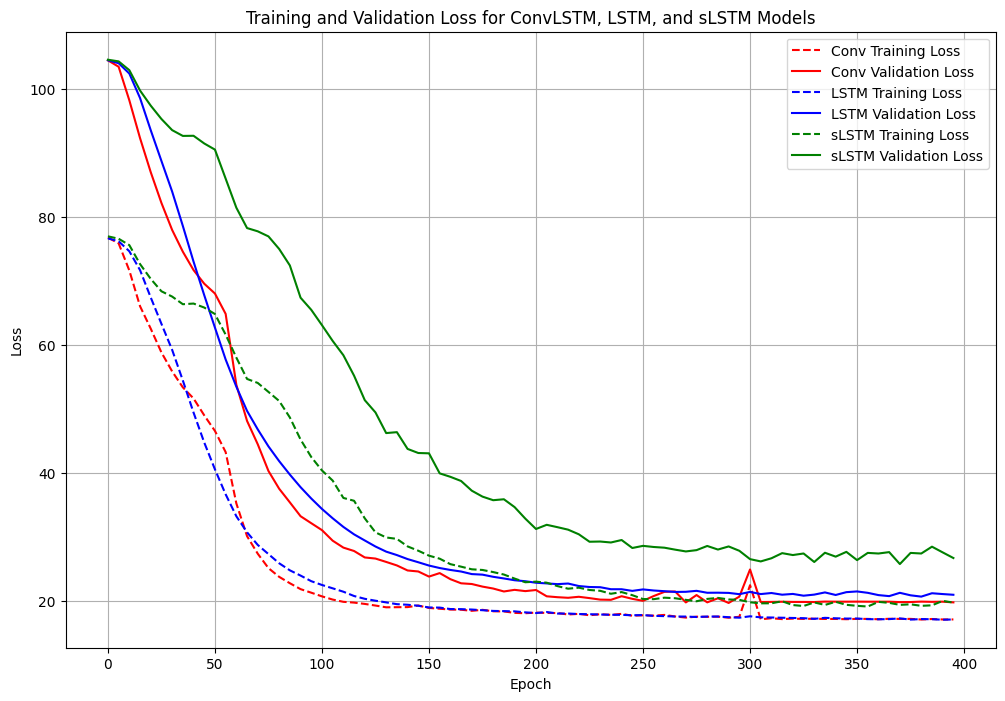

In [ ]:
# Plotting the training and validation losses for all three models
done_epochs = 5 * len(training_losses_conv)
epochs = range(0, done_epochs, 5)

plt.figure(figsize=(12, 8))

# Ploting Conv model losses
plt.plot(epochs, training_losses_conv, label='Conv Training Loss', color='red', linestyle='--')
plt.plot(epochs, validation_losses_conv, label='Conv Validation Loss', color='red', linestyle='-')

# Ploting LSTM model losses
plt.plot(epochs, training_losses_lstm, label='LSTM Training Loss', color='blue', linestyle='--')
plt.plot(epochs, validation_losses_lstm, label='LSTM Validation Loss', color='blue', linestyle='-')

# Ploting sLSTM model losses
plt.plot(epochs, slstm_training_losses, label='sLSTM Training Loss', color='green', linestyle='--')
plt.plot(epochs, slstm_validation_losses, label='sLSTM Validation Loss', color='green', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ConvLSTM, LSTM, and sLSTM Models')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def finalizator_conv(parameters):
    m = len(test_sequences)
    predict = pd.DataFrame(jax.jit(jax.vmap(conv_net_forward_pass, in_axes=(None, 0)))(parameters, test_sequences.reshape(m, sequence_length, 1)))

    predict.index = df[-m:].index

    actual_data = df[-m:]['Monthly Mean Total Sunspot Number']
    mae = abs(jax.jit(jax.vmap(conv_net_forward_pass, in_axes=(None, 0)))(parameters, test_sequences.reshape(m, sequence_length, 1)).reshape(-1) - test_targets).mean()
    rmse = jnp.sqrt(jnp.mean((jax.jit(jax.vmap(conv_net_forward_pass, in_axes=(None, 0)))(parameters, test_sequences.reshape(m, sequence_length, 1)).reshape(-1) - test_targets)**2))

    # Concatenate the original test data and the predicted values for visualization
    # predict_graphs = predict.rename(columns={0: 'Monthly Mean Total Sunspot Predicted'})
    actual_data = df[-m:]['Monthly Mean Total Sunspot Number']
    actual_data.index = predict.index
    predict_graphs = pd.concat([actual_data, predict], axis=1).rename(columns={0: 'Monthly Mean Total Sunspot Predicted'})

    # Create a plot of the original vs. predicted values
    graph = (predict_graphs.plot(figsize=(20, 8)),
             plt.title(f'Real x Predict - Model MAE: {mae:.2f} and RMSE: {rmse:.2f}'),
             plt.ylabel('Monthly Sunspot Mean'))

    return graph

def finalizator_lstm(parameters):
    m = len(test_sequences)
    predict = pd.DataFrame(jax.jit(jax.vmap(lstm_net_forward_pass, in_axes=(None, 0)))(parameters, test_sequences.reshape(m, sequence_length, 1)))

    predict.index = df[-m:].index

    actual_data = df[-m:]['Monthly Mean Total Sunspot Number']
    mae = abs(jax.jit(jax.vmap(lstm_net_forward_pass, in_axes=(None, 0)))(parameters, test_sequences.reshape(m, sequence_length, 1)).reshape(-1) - test_targets).mean()
    rmse = jnp.sqrt(jnp.mean((jax.jit(jax.vmap(lstm_net_forward_pass, in_axes=(None, 0)))(parameters, test_sequences.reshape(m, sequence_length, 1)).reshape(-1) - test_targets)**2))

    # Concatenate the original test data and the predicted values for visualization
    # predict_graphs = predict.rename(columns={0: 'Monthly Mean Total Sunspot Predicted'})
    actual_data = df[-m:]['Monthly Mean Total Sunspot Number']
    actual_data.index = predict.index
    predict_graphs = pd.concat([actual_data, predict], axis=1).rename(columns={0: 'Monthly Mean Total Sunspot Predicted'})

    # Create a plot of the original vs. predicted values
    graph = (predict_graphs.plot(figsize=(20, 8)),
             plt.title(f'Real x Predict - Model MAE: {mae:.2f} and RMSE: {rmse:.2f}'),
             plt.ylabel('Monthly Sunspot Mean'))

    return graph

def finalizator_slstm(parameters):
    m = len(test_sequences)
    predict = pd.DataFrame(jax.jit(jax.vmap(slstm_forward_pass, in_axes=(None, 0)))(parameters, test_sequences.reshape(m, sequence_length, 1)))

    predict.index = df[-m:].index

    actual_data = df[-m:]['Monthly Mean Total Sunspot Number']
    mae = abs(jax.jit(jax.vmap(slstm_forward_pass, in_axes=(None, 0)))(parameters, test_sequences.reshape(m, sequence_length, 1)).reshape(-1) - test_targets).mean()
    rmse = jnp.sqrt(jnp.mean((jax.jit(jax.vmap(slstm_forward_pass, in_axes=(None, 0)))(parameters, test_sequences.reshape(m, sequence_length, 1)).reshape(-1) - test_targets)**2))

    # Concatenate the original test data and the predicted values for visualization
    # predict_graphs = predict.rename(columns={0: 'Monthly Mean Total Sunspot Predicted'})
    actual_data = df[-m:]['Monthly Mean Total Sunspot Number']
    actual_data.index = predict.index
    predict_graphs = pd.concat([actual_data, predict], axis=1).rename(columns={0: 'Monthly Mean Total Sunspot Predicted'})

    # Create a plot of the original vs. predicted values
    graph = (predict_graphs.plot(figsize=(20, 8)),
             plt.title(f'Real x Predict - Model MAE: {mae:.2f} and RMSE: {rmse:.2f}'),
             plt.ylabel('Monthly Sunspot Mean'))

    return graph

(<Axes: title={'center': 'Real x Predict - Model MAE: 16.67 and RMSE: 24.04'}, ylabel='Monthly Sunspot Mean'>,
 Text(0.5, 1.0, 'Real x Predict - Model MAE: 16.67 and RMSE: 24.04'),
 Text(0, 0.5, 'Monthly Sunspot Mean'))

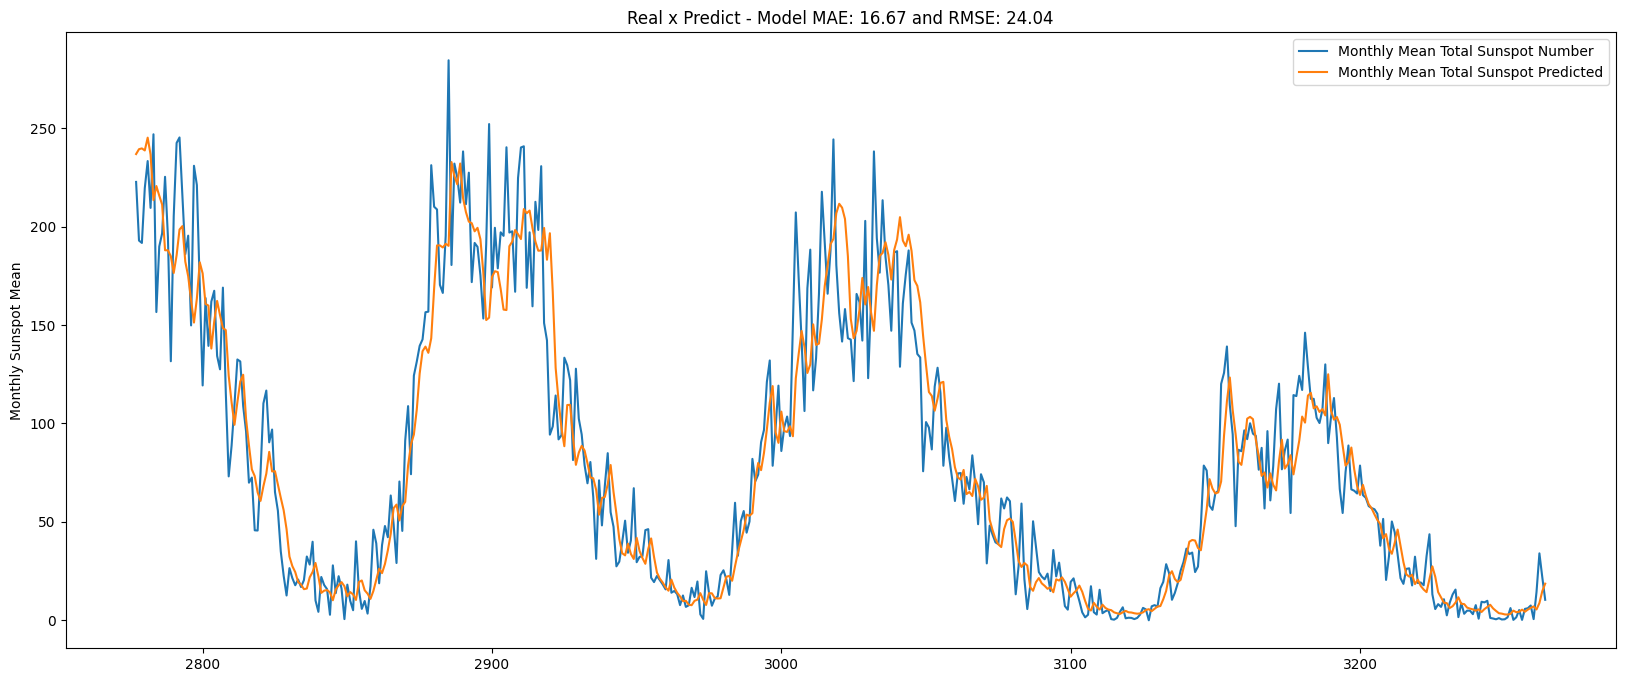

In [ ]:
finalizator_conv(conv_net_parameters)

(<Axes: title={'center': 'Real x Predict - Model MAE: 16.65 and RMSE: 24.00'}, ylabel='Monthly Sunspot Mean'>,
 Text(0.5, 1.0, 'Real x Predict - Model MAE: 16.65 and RMSE: 24.00'),
 Text(0, 0.5, 'Monthly Sunspot Mean'))

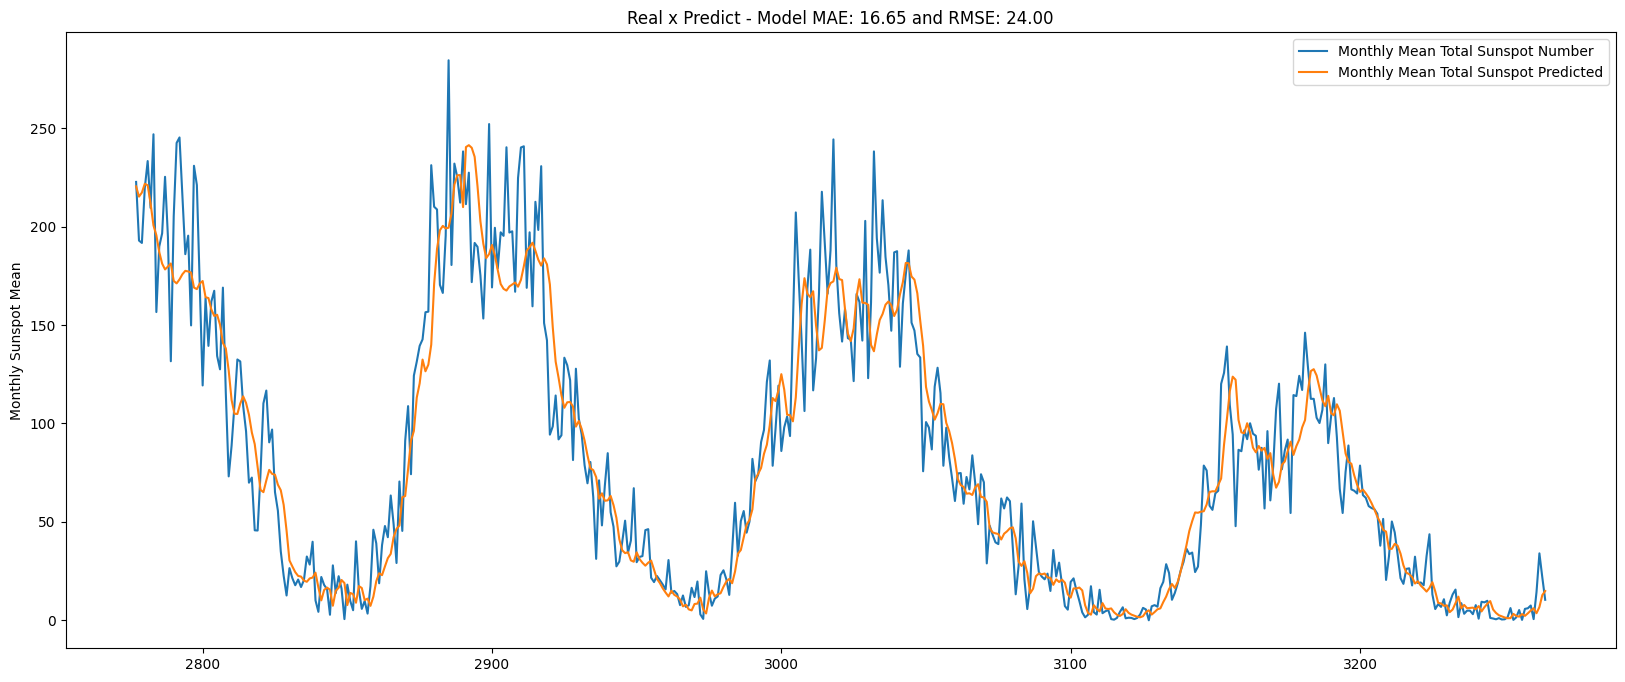

In [ ]:
finalizator_lstm(lstm_net_parameters)

(<Axes: title={'center': 'Real x Predict - Model MAE: 20.59 and RMSE: 31.24'}, ylabel='Monthly Sunspot Mean'>,
 Text(0.5, 1.0, 'Real x Predict - Model MAE: 20.59 and RMSE: 31.24'),
 Text(0, 0.5, 'Monthly Sunspot Mean'))

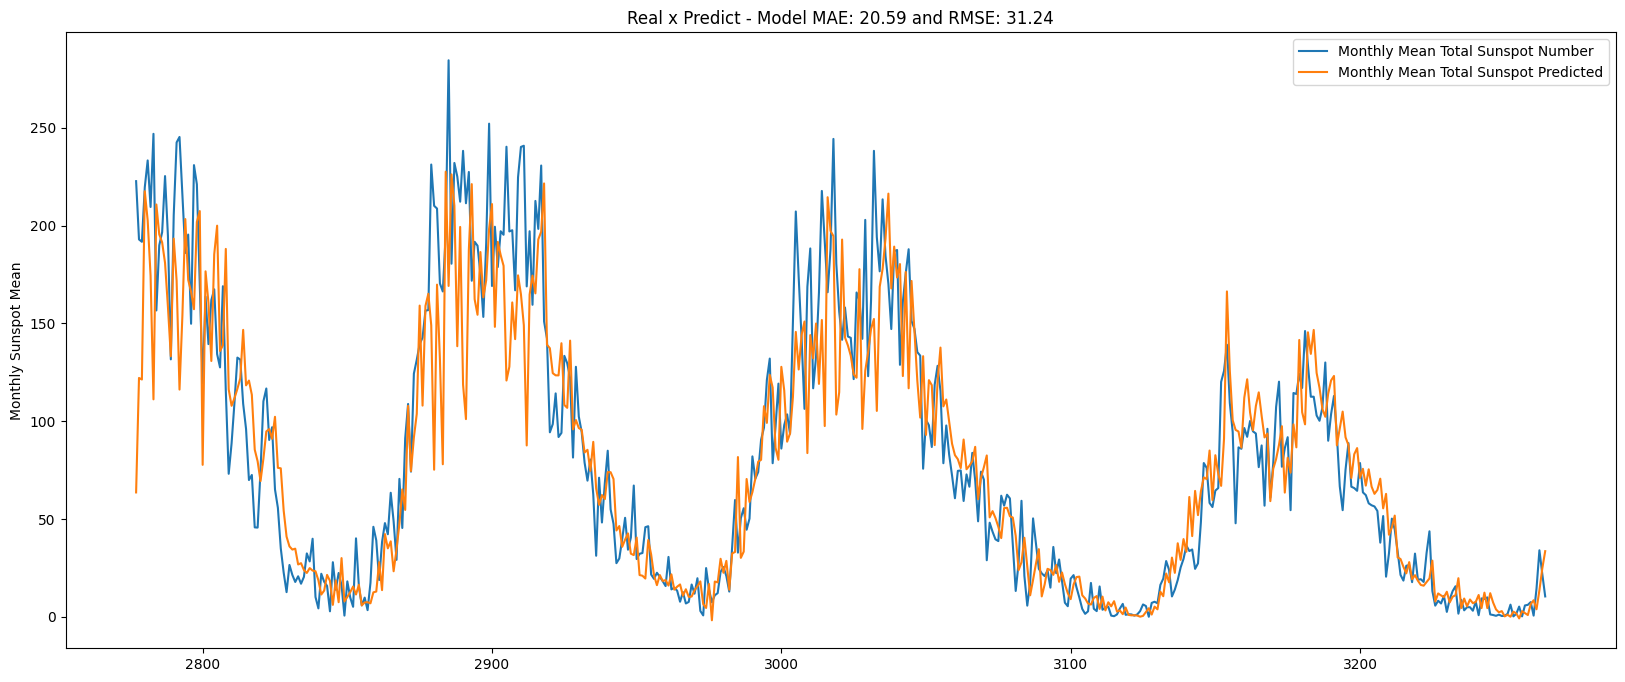

In [ ]:
finalizator_slstm(slstm_net_parameters)

### Exercise 2: Autoregressive generation (3 points)

For this exercise, run the trained model in an autoregressive fashion and show some examples of generated sequences. Note that the details will depend on the specific type of data (e.g., sampling text tokens, sampling pixels as discrete values, sampling pixels from a continuous range of colours, ...). For this, refer also to Section 8.4 of the book.

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code. Show some examples of generated sequences.*

**TODO**: Check How Models act in autoregresive mode: make generatios, visualize predictions and make some insights.

In [ ]:
def autoregressive_generation_conv(params, initial_sequence, num_generate):

    current_sequence = initial_sequence.copy()
    sequence_output = []
    for _ in range(num_generate):
        # Reshape to match the model's expected input shape
        input_seq = current_sequence.reshape(sequence_length, 1)

        # Predict the next value using the trained model

        prediction = conv_net_forward_pass(params, input_seq)

        # Append the prediction to the sequence_output
        next_value = prediction[0]
        sequence_output.append(next_value)
        current_sequence = jnp.append(current_sequence[1:], next_value)

    return sequence_output

def autoregressive_generation_lstm(params, initial_sequence, num_generate):

    current_sequence = initial_sequence.copy()
    sequence_output = []
    for _ in range(num_generate):
        # Reshape to match the model's expected input shape
        input_seq = current_sequence.reshape(sequence_length, 1)

        # Predict the next value using the trained model

        prediction = lstm_net_forward_pass(params, input_seq)

        # Append the prediction to the sequence_output
        next_value = prediction[0]
        sequence_output.append(next_value)
        current_sequence = jnp.append(current_sequence[1:], next_value)

    return sequence_output

def autoregressive_generation_slstm(params, initial_sequence, num_generate):

    current_sequence = initial_sequence.copy()
    sequence_output = []
    for _ in range(num_generate):
        # Reshape to match the model's expected input shape
        input_seq = current_sequence.reshape(sequence_length, 1)

        # Predict the next value using the trained model
        prediction = slstm_forward_pass(params, input_seq)

        # Append the prediction to the sequence_output
        next_value = prediction[0]
        sequence_output.append(next_value)
        current_sequence = jnp.append(current_sequence[1:], next_value)

    return sequence_output


def plot_generated_sequences(generated_sequence, seed_index, NUM_GENERATE):
    #True Data
    actual_data = test_targets[seed_index:(seed_index+NUM_GENERATE)]

    plt.figure(figsize=(14, 6))
    plt.plot(range(len(generated_sequence)), generated_sequence, label='Generated_Sequence', color='black', linestyle='-')
    plt.plot(range(len(actual_data)), actual_data, label='True Sequence', color='orange', linestyle='--')

    plt.xlabel('Months')
    plt.ylabel('Monthly Mean Total Sunspot Number')
    plt.title('Autoregressive Generation of Sunspot Numbers')
    plt.legend()
    plt.grid(True)
    plt.show()

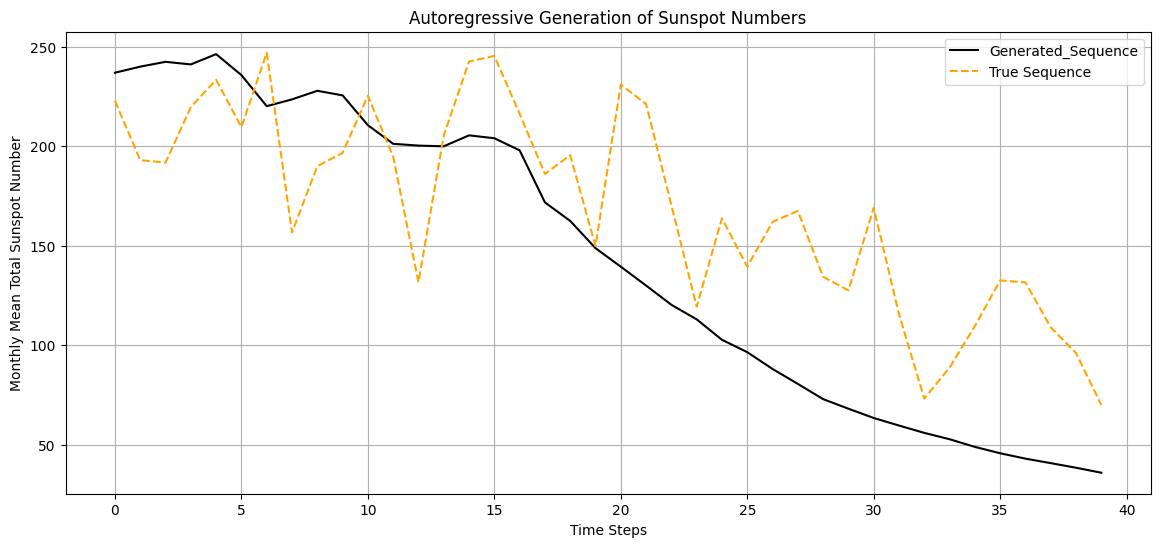

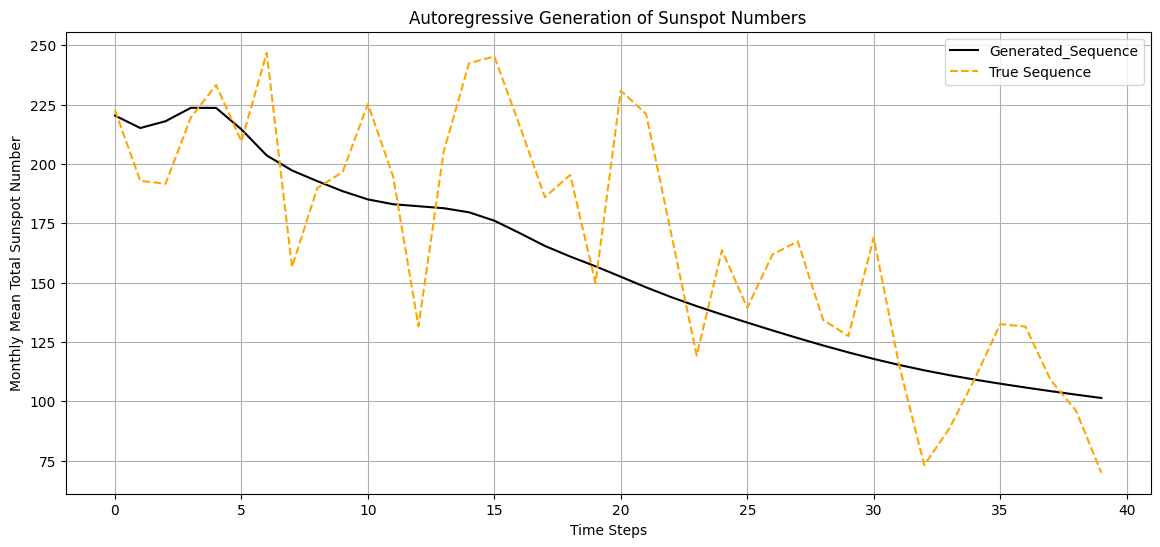

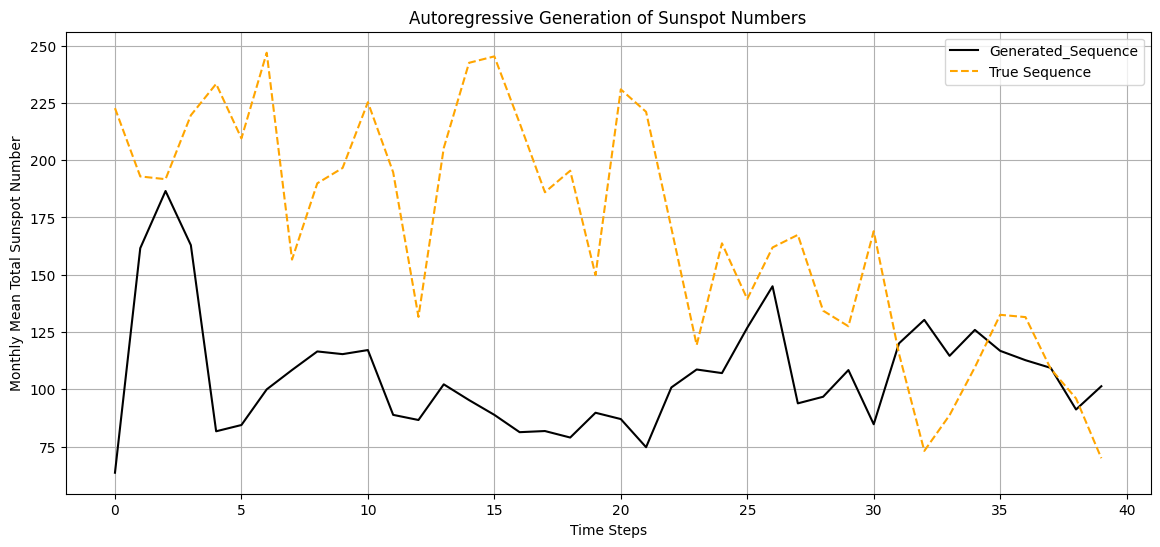

In [ ]:
# Select a seed sequence from the test set
seed_index = 0
initial_sequence = test_sequences[seed_index]

# Number of future points to generate
NUM_GENERATE = 40

# Generate the sequences
generated_seq_conv = autoregressive_generation_conv(conv_net_parameters, initial_sequence, NUM_GENERATE)
generated_seq_lstm = autoregressive_generation_lstm(lstm_net_parameters, initial_sequence, NUM_GENERATE)
generated_seq_slstm = autoregressive_generation_slstm(slstm_net_parameters, initial_sequence, NUM_GENERATE)



# Plot the results
plot_generated_sequences(generated_seq_conv, seed_index, NUM_GENERATE)
plot_generated_sequences(generated_seq_lstm, seed_index, NUM_GENERATE)
plot_generated_sequences(generated_seq_slstm, seed_index, NUM_GENERATE)

In [ ]:
# On the actual data there is a visible trend from 20 month till the end, that the value
# tend to decrease

#As seen Conv+Lstm Model tends to rapedly decrease it's prediction after 17th prediction in a row
#LSTM Model smoothly decreases after 7th prediction
#sLSTM Model behaves pretty unpredictable, but stays on the same level of prediction

#First model predicts tren best